# Project - Investigating the Twitter WeRateDogs Archive

### Table of Contents

<ul>
    <li><a href="#intro">Introduction - Data Gathering</a></li>
    <li><a href="#assessing">Data Assessing</a></li>
    <li><a href="#cleaning">Data Cleaning</a></li>
    <li><a href="#da">Data Analysis</a></li>
    <li><a href="#insights"> Insights</a></li>
</ul>

<a id='intro'></a>
## Introduction - Data Gathering
This project is investigating the tweet archive of Twitter user @dog_rates also known as WeRateDogs. They rate people's dogs with a humorous comment about the dog. The rating comes with a denominator of 10 and the numerator is always greater than 10.
The project is investigating three datasets.
1. The enhanced twitter archive
2. Data gathered from twitter API (retweet count, favorite count)
3. Image Predictions File: Which is the output gotten by running the dog's image through a neural network. Columns include:
    1. tweet_id: The last part of the tweet url after "status/"-> https://twitter.com/dog-rates/status/88,,,,921
    2. TP1: The algorithm's number 1 prediction for the image in the tweet.
    3. TP1_conf: How confident the algorithm is in its number 1 prediction.
    4. TP1_dog: Whether or not the number 1 prediction is a breed of dog.
    5. TP2: The algorithm's second most likely prediction.
    6. TP2_conf: How confident the algorithm is in its number 2 prediction.
    7. TP2_dog: Whether or not the number 2 prediction is a breed of dog. e.t.c


In [2]:
#import libraries
import pandas as pd
import numpy as np
import requests as r
import tweepy as tw
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
# authenticating twitter api credentials
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [3]:
#load twitter-archive-enhanced.csv
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [16]:
#Get Neural Network Predictions
response = r.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [17]:
#check to see that we got a response from the url
response.text[0:200]

'tweet_id\tjpg_url\timg_num\tp1\tp1_conf\tp1_dog\tp2\tp2_conf\tp2_dog\tp3\tp3_conf\tp3_dog\n666020888022790149\thttps://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg\t1\tWelsh_springer_spaniel\t0.465074\tTrue\tcollie\t0.156665'

In [18]:
#Inspect df_twitter_archive to see the structure of the dataframe
df_twitter_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [8]:
# instantiating the api
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# creating API object
api = tw.API(auth)

In [10]:
#Gather remaining data, separating the tweet_ids that failed
import time
fav = []
retweet = []
tweet_id_new = []
fail_tweet_id = []
start_time = time.time()
for item in df_twitter_archive['tweet_id']:
    try:
        tweet_details = api.get_status(item)
        tweet_id_new.append(item)
        fav.append(tweet_details.favorite_count)
        retweet.append(tweet_details.retweet_count)
    except tw.errors.NotFound:
        fail_tweet_id.append(item)
        continue
    except tw.errors.Forbidden:
        fail_tweet_id.append(item)
        continue
    except tw.errors.Unauthorized:
        fail_tweet_id.append(item)
        continue
    except tw.errors.HTTPException:
        fail_tweet_id.append(item)
        continue
    except tw.errors.TweepyException:
        fail_tweet_id.append(item)
        continue
           
end_time = time.time()
print(end_time - start_time)
print(fail_tweet_id)

4737.157113075256
[888202515573088257, 873697596434513921, 872668790621863937, 872261713294495745, 869988702071779329, 866816280283807744, 861769973181624320, 856602993587888130, 856330835276025856, 851953902622658560, 851861385021730816, 845459076796616705, 844704788403113984, 842892208864923648, 837366284874571778, 837012587749474308, 829374341691346946, 827228250799742977, 812747805718642688, 802247111496568832, 794332329137291264, 779123168116150273, 775096608509886464, 771004394259247104, 770743923962707968, 766864461642756096, 759923798737051648, 759566828574212096, 754011816964026368, 680055455951884288, 671744970634719232, 669753178989142016]


In [11]:
#Form a dataframe using the list
data = {'tweet_id': tweet_id_new, 'favorite_count': fav, 'retweet_count':retweet}
df_tweet_json = pd.DataFrame.from_dict(data)

In [12]:
#Save data downloaded from API to a text file
#df_tweet_json.to_csv('tweet_json.txt', header=None, index=None, sep=' ', mode='a')
df_tweet_json.to_json('tweet-json.txt', orient='columns')

In [13]:
#Save failed tweet ids to a text file
df_failed_tweet_id = pd.DataFrame.from_dict({'tweet_id':fail_tweet_id}, orient='index')
df_failed_tweet_id.to_csv('tweet-json_fail.txt', header=None, index=None, sep=' ', mode='a')


In [32]:
#Converting the tab separated values we read into a pandas dataframe
responseList = response.content.decode('utf-8').split('\n')
responseList = responseList[1:len(responseList)-1]
column_names = ['tweet_id','jpg_url','img_num','tp1','tp1_confidence','tp1_dog','tp2','tp2_confidence','tp2_dog','tp3','tp3_confidence','tp3_dog']
df_prediction = pd.DataFrame(columns = column_names)

for item in responseList:
    ite = item.split('\t')
    df_prediction.loc[len(df_prediction)] = ite

In [33]:
#Writing the Tab Separated Values into a TSV File
df_prediction.to_csv('predictions.tsv', sep="\t")

In [4]:
#Code to read tweet-json.txt
df_new = pd.read_json('tweet-json.txt')
df_new

,tweet_id,favorite_count,retweet_count
0,892420643555336193,33847,7024
1,892177421306343426,29364,5304
2,891815181378084864,22086,3488
3,891689557279858688,36987,7237
4,891327558926688256,35364,7775
...,...,...,...
2319,666049248165822465,89,37
2320,666044226329800704,247,115
2321,666033412701032449,100,36
2322,666029285002620928,112,39


In [5]:
#Code to read prediction if no internet access
df_prediction = pd.read_csv('predictions.tsv', sep="\t")

<a id='assessing'></a>
## Data Assessing



In [36]:
df_new.shape

(2324, 3)

In [37]:
df_prediction.shape

(2075, 13)

In [38]:
df_twitter_archive.shape

(2356, 17)

### Structure Issue 1

*df_twitter_archive does not have the same number of rows as df_new*

### Structure Issue 2
*Our df_twitter_archive dataframe has the column `timestamp` not descriptive enough*

In [39]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2324 non-null   int64
 1   favorite_count  2324 non-null   int64
 2   retweet_count   2324 non-null   int64
dtypes: int64(3)
memory usage: 72.6 KB


In [40]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      2075 non-null   int64  
 1   tweet_id        2075 non-null   int64  
 2   jpg_url         2075 non-null   object 
 3   img_num         2075 non-null   int64  
 4   tp1             2075 non-null   object 
 5   tp1_confidence  2075 non-null   float64
 6   tp1_dog         2075 non-null   bool   
 7   tp2             2075 non-null   object 
 8   tp2_confidence  2075 non-null   float64
 9   tp2_dog         2075 non-null   bool   
 10  tp3             2075 non-null   object 
 11  tp3_confidence  2075 non-null   float64
 12  tp3_dog         2075 non-null   bool   
dtypes: bool(3), float64(3), int64(3), object(4)
memory usage: 168.3+ KB


In [41]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Quality Issue 1
*`in_reply_to_status_id,in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id` are of float type instead of int.*

### Quality Issue 2
*`retweeted_status_timestamp and timestamp` should be of type datetime but it is a string.*

In [42]:
df_new.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,33847,7024
1,892177421306343426,29364,5304
2,891815181378084864,22086,3488
3,891689557279858688,36987,7237
4,891327558926688256,35364,7775


In [43]:
df_prediction.head()

,Unnamed: 0,tweet_id,jpg_url,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
0,0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [44]:
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [45]:
df_new.tail()

,tweet_id,favorite_count,retweet_count
2319,666049248165822465,89,37
2320,666044226329800704,247,115
2321,666033412701032449,100,36
2322,666029285002620928,112,39
2323,666020888022790149,2293,424


In [57]:
df_prediction.tail()

,Unnamed: 0,tweet_id,jpg_url,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
2070,2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [58]:
df_twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [64]:
df_new['favorite_count'].value_counts()

0        160
2248       4
2794       3
651        3
372        3
        ... 
8789       1
19030      1
4697       1
6746       1
2082       1
Name: favorite_count, Length: 1987, dtype: int64

In [65]:
df_new['retweet_count'].value_counts()

328     7
50      5
288     5
441     5
182     5
       ..
1834    1
5942    1
3899    1
1852    1
4092    1
Name: retweet_count, Length: 1646, dtype: int64

In [66]:
df_prediction['tp1_confidence'].value_counts()

0.366248    2
0.713293    2
0.375098    2
0.636169    2
0.611525    2
           ..
0.713102    1
0.765266    1
0.491022    1
0.905334    1
1.000000    1
Name: tp1_confidence, Length: 2006, dtype: int64

In [67]:
df_prediction['tp2_confidence'].value_counts()

0.069362    3
0.027907    2
0.193654    2
0.271929    2
0.003143    2
           ..
0.138331    1
0.254884    1
0.090644    1
0.219323    1
0.016301    1
Name: tp2_confidence, Length: 2004, dtype: int64

In [68]:
df_prediction['tp3_confidence'].value_counts()

0.094759    2
0.035711    2
0.000428    2
0.044660    2
0.162084    2
           ..
0.024007    1
0.132820    1
0.002099    1
0.083643    1
0.033835    1
Name: tp3_confidence, Length: 2006, dtype: int64

In [69]:
df_prediction['tp1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
boathouse               1
ice_lolly               1
lion                    1
stove                   1
dhole                   1
Name: tp1, Length: 378, dtype: int64

In [70]:
df_prediction['tp2'].value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
water_buffalo           1
cardigan                1
crutch                  1
shower_curtain          1
dumbbell                1
Name: tp2, Length: 405, dtype: int64

In [71]:
df_prediction['tp3'].value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
pot                    1
jaguar                 1
shovel                 1
binder                 1
dugong                 1
Name: tp3, Length: 408, dtype: int64

In [72]:
df_prediction['tp1_dog'].value_counts()

True     1532
False     543
Name: tp1_dog, dtype: int64

In [73]:
df_prediction['tp2_dog'].value_counts()

True     1553
False     522
Name: tp2_dog, dtype: int64

In [74]:
df_prediction['tp3_dog'].value_counts()

True     1499
False     576
Name: tp3_dog, dtype: int64

In [75]:
df_twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

### Quality Issue 3
*`rating_numerator` has certain values not greater than 10*

In [76]:
df_twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### Quality Issue 4
*`rating_denominator` has certain values not equal to 10*

In [77]:
df_twitter_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [78]:
df_twitter_archive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [79]:
df_twitter_archive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [80]:
df_twitter_archive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [81]:
df_twitter_archive['name'].value_counts()

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Furzey       1
Zeus         1
Gin          1
Zuzu         1
Edmund       1
Name: name, Length: 957, dtype: int64

### Quality Issue 5
*`name` has some invalid names as name of dog*

In [82]:
sum(df_new.duplicated())

0

In [83]:
sum(df_prediction.duplicated())

0

In [84]:
sum(df_twitter_archive.duplicated())

0

No duplicate data in our dataframes.

In [89]:
#find our invalid names using islowercase since all valid dog names start with upper case letters
islower = df_twitter_archive['name'].str.islower()
true = 0
false = 0
for islow in islower:
    if(islow==True):
        true = true+1
    else:
        false = false+1
print(true)
assert true > 0
    


109


We have 109 entries with invalid dog names.

In [90]:
#Test for negative certainty of predictions
df_prediction.query('tp1_confidence < 0')

,Unnamed: 0,tweet_id,jpg_url,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog


In [91]:
df_prediction.query('tp2_confidence < 0')

,Unnamed: 0,tweet_id,jpg_url,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog


In [92]:
df_prediction.query('tp3_confidence < 0')

,Unnamed: 0,tweet_id,jpg_url,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog


*We do not certainty of predictions that are less than zero*

In [93]:
df_twitter_archive[df_twitter_archive['timestamp'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


We do not have a null timestamp entry.

In [94]:
df_twitter_archive[df_twitter_archive['name'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


We do not have null dog names.

In [6]:
df_twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1204,716080869887381504,NaN,NaN,2016-04-02 01:52:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super majestic doggo and a sunset 11/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716080869...,11,10,None,doggo,None,None,None
581,800443802682937345,NaN,NaN,2016-11-20 21:00:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sampson. He's about to ...,7.761133e+17,4.196984e+09,2016-09-14 17:40:06 +0000,https://twitter.com/dog_rates/status/776113305...,11,10,Sampson,None,None,pupper,None
1322,706291001778950144,NaN,NaN,2016-03-06 01:31:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're just relaxin and having a swell ti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706291001...,11,10,None,None,None,None,None
1523,690607260360429569,6.903413e+17,467036706.0,2016-01-22 18:49:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 @LightningHoltt,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
215,851224888060895234,NaN,NaN,2017-04-10 00:06:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Snoop. His number one passion is sticking...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/851224888...,13,10,Snoop,None,None,None,None


### Structural Issue 3
A tidy  data is one in which every variable forms a column, every observational unit forms a row and each type of observational unit forms a table. `df_twitter_archive` have a structural issue. Certain rows should form a different table (retweets) and certain columns should become rows


### Structural Issue 4

The three dataframes are of the same observational unit but they are not in one dataframe.

### Quality Issue 6

Drop rows from df_twitter_archive that threw HTTP and Tweepy Error

In [97]:
df_prediction.at[60,'tp3_confidence']

0.00180397

In [98]:
df_prediction.at[69,'tp3_confidence']

0.140703

In [99]:
df_prediction.at[69,'tp1_confidence']

0.33583

In [100]:
df_prediction.at[68,'tp1_confidence']

0.949892

In [101]:
df_prediction.at[69,'tp2_confidence']

0.265278

In [102]:
df_prediction.at[77,'tp2_confidence']

0.00630049

### Quality Issue 7

There are data duplicates after the melting of column doggo, pupper, puppo and floofer

### Quality Issue 8

`tp1, tp2, tp3` have their text separated by an underscore instead of spaces.

<a id='cleaning'></a>
## Data Cleaning
### Define
#### Quality
1. Make `in_reply_to_status_id,in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id` to become int.
2. Make `retweeted_status_timestamp and timestamp` to become datetime and not string. 
3. Make all `rating_numerator` not greater than 10 to become the mode of the rating numerator field.
4. Make all `rating_denominator` to become exactly 10.
5. Change all names of dogs bearing 'a' or 'an' or 'the' or more generally starting with lower case to be np.nan.
6. Drop tweets that threw HTTP Error and Tweepy Error from df_twitter_archive.
7. Remove data duplicates after the melting of columns `doggo, floofer, pupper, puppo`.
8. Remove all underscores in `tp1, tp2, tp3` entry.
9. Drop `in_reply_to_status_id,in_reply_to_user_id` since it all contains null values in  retweets table created from df_twitter_archive and drop all `in_reply_to_status_id,in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id` in the twitter_archive.

#### Structure
1. Make df_twitter_archive to have equal number of rows with df_new.
2. Make `timestamp` in df_twitter_archive to become `tweet_timestamp`.
3. Create a retweeted table from df_twitter_archive.
4. Merge the dataframes as they are of the same observational unit.
5. Melt df_twitter_archive columns - doggo, floofer, pupper and puppo to form rows instead and remove resulting duplicates.

### Coding

**Creating a copy of dataframes for cleaning purpose**

In [6]:
df_twitter_archive_clean = df_twitter_archive.copy()
df_prediction_clean = df_prediction.copy()
df_new_clean = df_new.copy()


**Reading the tweet id file that throwed the NOT FOUND HTTP error and dropping them from df_twitter_archive_clean**

In [7]:
#Remove tweets from df_twitter_archive that raised a NOT FOUND Http error
#read the invalid tweet ids
with open('tweet-json_fail.txt', encoding='utf-8') as file:
    lines = file.readlines()
    data = lines[0][:-1].split(" ")
for d in data:
    invalid_tweet = df_twitter_archive_clean.query('tweet_id == '+d)
    df_twitter_archive_clean.drop(invalid_tweet.index, inplace=True)

#### Testing

In [8]:
df_twitter_archive_clean.shape

(2324, 17)

In [9]:
df_prediction_clean.shape

(2075, 13)

In [10]:
df_new_clean.shape

(2324, 3)

In [11]:
df_twitter_archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1066,740699697422163968,NaN,NaN,2016-06-09 00:19:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chip. He only mowed half the yard. 8/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/740699697...,8,10,Chip,None,None,None,None
1959,673576835670777856,NaN,NaN,2015-12-06 18:56:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Sun burnt dog here. Quite large. Wants to prom...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673576835...,7,10,None,None,None,None,None
51,882268110199369728,NaN,NaN,2017-07-04 16:01:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Alfy. You're witnessing his first wate...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882268110...,13,10,Alfy,None,None,None,None
844,766693177336135680,NaN,NaN,2016-08-19 17:47:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Brudge. He's a Doberdog. Going to be h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/766693177...,11,10,Brudge,None,None,None,None
1181,719332531645071360,NaN,NaN,2016-04-11 01:13:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pippa. She managed to start the car bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/719332531...,11,10,Pippa,None,None,None,None


**Create a retweet Dataframe and Drop tweets that are retweets from df_twitter_archive and create a new dataframe for retweets.**

In [12]:
#Sieve out all retweets
retweets = df_twitter_archive_clean.loc[df_twitter_archive_clean['retweeted_status_id'].notnull()]

In [13]:
#drop all retweets
for index, row in retweets.iterrows():
    df_twitter_archive_clean.drop(index, inplace=True)

#### Testing

In [14]:
retweets.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None


In [15]:
retweet_test = df_twitter_archive_clean.loc[df_twitter_archive_clean['retweeted_status_id'].notnull()]

In [16]:
retweet_test

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [17]:
df_new_clean.shape

(2324, 3)

In [18]:
df_twitter_archive_clean.shape

(2164, 17)

In [19]:
df_prediction_clean.shape

(2075, 13)

**Drop retweets from df_new_clean Dataframe and add the favorite_count and retweet_count column for retweets Dataframe**

We need to extract the favorite count and retweet count of the retweeted table items from `df_new_clean` in order to make df_new_clean to be of the same number of rows with `df_twitter_archive`

In [20]:
retweet_fav_count = []
retweet_retweet_count = []

for item in retweets['tweet_id']:
    tweet_id = str(item)
    df_new_clean_query = df_new.query("tweet_id == @tweet_id")
    index = df_new_clean_query.index
    retweet_fav_count.append(int(df_new_clean_query.at[index[0], 'favorite_count']))
    retweet_retweet_count.append(int(df_new_clean_query.at[index[0], 'retweet_count']))
    df_new_clean.drop(index, inplace=True)
#insert the new columns to retweet table 
retweets.insert(17,'favorite_count',retweet_fav_count)
retweets.insert(18,'retweet_count',retweet_retweet_count)

#### Testing

In [21]:
retweets.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None,0,93
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None,0,15460


In [22]:
retweets.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'favorite_count', 'retweet_count'],
      dtype='object')

**Make timestamp in df_twitter_archive to become tweet_timestamp**

In [23]:
df_twitter_archive_clean.rename(columns={'timestamp':'tweet_timestamp'}, inplace=True)

#### Testing

In [24]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'tweet_timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [26]:
df_twitter_archive_clean[df_twitter_archive_clean['retweeted_status_user_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,tweet_timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


**Drop `in_reply_to_status_id,in_reply_to_user_id` since it all contains null values in  retweets table created from df_twitter_archive and drop all `in_reply_to_status_id,in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id` in the twitter_archive**

In [27]:
#drop in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id
df_twitter_archive_clean = df_twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id'], axis=1)
#drop in_reply_to_status_id,in_reply_to_user_id from retweets
retweets = retweets.drop(['in_reply_to_status_id','in_reply_to_user_id'], axis=1)

### Testing

In [30]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'tweet_timestamp', 'source', 'text',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [31]:
retweets.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'favorite_count',
       'retweet_count'],
      dtype='object')

**All retweeted_status_timestamp field in df_twitter_archive_clean are null so drop the column as well**

In [32]:
df_twitter_archive_clean.drop(['retweeted_status_timestamp'], axis=1, inplace=True)


#### Testing

In [33]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'tweet_timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

In [34]:
retweets.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'favorite_count',
       'retweet_count'],
      dtype='object')

**Make retweeted_status_timestamp and timestamp to become datetime and not object.**

This will be performed on the retweet dataframe and we set all entries in `df_twitter_archive_clean` to zero since we do not have retweeted tweets in it any more

In [35]:
retweets['retweeted_status_timestamp'] = pd.to_datetime(retweets['retweeted_status_timestamp'])

In [36]:
df_twitter_archive_clean['tweet_timestamp'] = pd.to_datetime(df_twitter_archive_clean['tweet_timestamp'])

#### Testing

In [37]:
df_twitter_archive_clean['tweet_timestamp'].dtypes

datetime64[ns, UTC]

In [38]:
retweets['retweeted_status_timestamp'].dtypes

datetime64[ns, UTC]

In [39]:
retweets['retweeted_status_timestamp'].sample(2)

78    2017-06-19 17:14:49+00:00
656   2016-06-25 17:31:25+00:00
Name: retweeted_status_timestamp, dtype: datetime64[ns, UTC]

**Remove all underscores in `tp1, tp2, tp3` entry.**

In [92]:
def removeUnderscore(text):
    print(text)
    tex = text.replace("_"," ")
    return tex
df_prediction_clean['tp1']= df_prediction_clean['tp1'].apply(lambda x: removeUnderscore(x))

In [41]:
df_prediction_clean['tp2']= df_prediction_clean['tp2'].apply(lambda x: removeUnderscore(x))

In [42]:
df_prediction_clean['tp3']= df_prediction_clean['tp3'].apply(lambda x: removeUnderscore(x))

#### Testing

In [43]:
df_prediction_clean.head(3)

,Unnamed: 0,tweet_id,jpg_url,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
0,0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


**Make all rating_numerator not greater than 10 to become the mode of the rating numerator field**

In [44]:
mode = df_twitter_archive_clean['rating_numerator'].mode().values[0]
def makeMode(number, mode):
    numerator = 0
    if number < 10:
        numerator = mode
    else:
        numerator = number
    return numerator
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean['rating_numerator'].apply(lambda x:makeMode(x,mode))

#### Testing

In [45]:
df_twitter_archive_clean.query('rating_numerator < 10')

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [46]:
df_twitter_archive_clean.sample(5)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1279,708845821941387268,2016-03-13 02:43:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with magic eyes. Not wearing a...,https://twitter.com/dog_rates/status/708845821...,12,10,None,None,None,pupper,None
1386,700518061187723268,2016-02-19 03:11:35+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Vincent. He's the man your girl is wit...,https://twitter.com/dog_rates/status/700518061...,10,10,Vincent,None,None,None,None
1978,672984142909456390,2015-12-05 03:41:37+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Very happy pup here. Always smiling. Loves his...,https://twitter.com/dog_rates/status/672984142...,12,10,None,None,None,None,None
1397,699779630832685056,2016-02-17 02:17:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Take all my money. 10/10 https://t.co/B28ebc5LzQ,https://twitter.com/dog_rates/status/699779630...,10,10,None,None,None,None,None
1431,697516214579523584,2016-02-10 20:23:19+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Say hello to Pherb. He does parkour. 9/10 http...,https://vine.co/v/i1LriMBmX6W,12,10,Pherb,None,None,None,None


**Make all rating_denominator to become exactly 10**

In [47]:
df_twitter_archive_clean['rating_denominator'] = df_twitter_archive_clean['rating_denominator'].apply(lambda x: 10)

#### Testing

In [48]:
df = df_twitter_archive_clean.query("rating_denominator > 10")
df

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [49]:
df = df_twitter_archive_clean.query("rating_denominator < 10")
df

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [50]:
df = df_twitter_archive_clean.query("rating_denominator == 10")
df.head(2)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


**Change all names of dogs bearing 'a' or 'an' or 'the' or more generally starting with lower case letter to be np.nan**

In [51]:
def makeNameNaN():
    mask = df_twitter_archive_clean['name'].str.islower() 
    column_name = 'name' 
    df_twitter_archive_clean.loc[mask, column_name] = np.nan
makeNameNaN()

#### Testing

In [52]:
islower = df_twitter_archive_clean['name'].str.islower()
false = 0
true = 0
for islow in islower:
    if(islow == True):
        true = true+1
    else:
        false = false+1
print(true)

0


We now have zero dog names which are invalid dog names.

**Merging df_new_clean and df_twitter_archive_clean and df_prediction**

In [53]:
#check to see that they are of equal number of rows
df_new_clean.shape[0]

2164

In [54]:
df_twitter_archive_clean.shape[0]

2164

In [114]:
df_master = df_twitter_archive_clean.merge(df_new_clean, how='outer', on='tweet_id')

In [115]:
#merging df_master and df_prediction
df_master = df_master.merge(df_prediction, how='outer', on='tweet_id')

#### Testing

In [116]:
df_master.sample(2)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
1748,673956914389192708,2015-12-07 20:07:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is one esteemed pupper. Just graduated co...,https://twitter.com/dog_rates/status/673956914...,10.0,10.0,NaN,None,None,...,1.0,pug,0.586161,True,Brabancon_griffon,0.082744,True,Chihuahua,0.045878,True
353,821407182352777218,2017-01-17 17:21:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sundance. He's a doggo drummer. Even s...,https://twitter.com/dog_rates/status/821407182...,14.0,10.0,Sundance,doggo,None,...,1.0,Irish_setter,0.505496,True,vizsla,0.168747,True,Chesapeake_Bay_retriever,0.111311,True


In [117]:
df_twitter_archive_clean.dtypes

tweet_id                            int64
tweet_timestamp       datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
name                               object
doggo                              object
floofer                            object
pupper                             object
puppo                              object
dtype: object

In [119]:
df_prediction.query('tweet_id == 673956914389192708')

,Unnamed: 0,tweet_id,jpg_url,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
413,413,673956914389192708,https://pbs.twimg.com/media/CVpgPGwWoAEV7gG.jpg,1,pug,0.586161,True,Brabancon_griffon,0.082744,True,Chihuahua,0.045878,True


**Correct Datatypes in df_master**

In [120]:
df_master['rating_numerator'] = df_master['rating_numerator'].fillna(0)

In [121]:
df_master['rating_denominator'] = df_master['rating_denominator'].fillna(0)

In [122]:
df_master['favorite_count'] = df_master['favorite_count'].fillna(0)

In [123]:
df_master['retweet_count'] = df_master['retweet_count'].fillna(0)

In [124]:
df_master.tail(4)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
2252,873697596434513921,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2253,877611172832227328,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,Irish_setter,0.364729,True,golden_retriever,0.202907,True,Irish_terrier,0.107473,True
2254,885311592912609280,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True
2255,888202515573088257,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,2.0,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True


In [125]:
df_master = df_master.astype({'rating_numerator':'int','rating_denominator':'int','favorite_count':'int','retweet_count':'int','tp1_dog':'bool','tp2_dog':'bool','tp3_dog':'bool'})

### Testing

In [126]:
df_master.dtypes

tweet_id                            int64
tweet_timestamp       datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int32
rating_denominator                  int32
name                               object
doggo                              object
floofer                            object
pupper                             object
puppo                              object
favorite_count                      int32
retweet_count                       int32
Unnamed: 0                        float64
jpg_url                            object
img_num                           float64
tp1                                object
tp1_confidence                    float64
tp1_dog                              bool
tp2                                object
tp2_confidence                    float64
tp2_dog                              bool
tp3                               

In [127]:
df_master.tail(5)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
2251,872261713294495745,NaT,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,2.0,Labrador_retriever,0.972019,True,flat-coated_retriever,0.008178,True,Chesapeake_Bay_retriever,0.007359,True
2252,873697596434513921,NaT,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,1.0,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2253,877611172832227328,NaT,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,1.0,Irish_setter,0.364729,True,golden_retriever,0.202907,True,Irish_terrier,0.107473,True
2254,885311592912609280,NaT,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,1.0,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True
2255,888202515573088257,NaT,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,2.0,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True


In [128]:
df_master.head(5)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


**Remove all underscores in `tp1, tp2, tp3` entry.**

In [131]:
def handleFloatObject(text):
    tex = str(text).split("_")
    final = tex[0]
    for t in tex[1:]:
        final = final+" "+t
    return final

In [132]:
df_master['tp1']= df_master['tp1'].apply(lambda x: handleFloatObject(x))

In [133]:
df_master['tp2']= df_master['tp2'].apply(lambda x: handleFloatObject(x))

In [134]:
df_master['tp3']= df_master['tp3'].apply(lambda x: handleFloatObject(x))

### Testing

In [136]:
df_master.head(5)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,...,1.0,paper towel,0.170278,False,Labrador retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,...,2.0,basset,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True


## Cleaning Retweets Dataframe

In [137]:
retweets.sample(2)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
601,798665375516884993,2016-11-15 23:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lola. She fell asleep o...,6.718968e+17,4.196984e+09,2015-12-02 03:40:57+00:00,https://twitter.com/dog_rates/status/671896809...,10,10,Lola,None,None,None,None,0,3689
574,801127390143516673,2016-11-22 18:17:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Anakin. He strives to r...,7.757333e+17,4.196984e+09,2016-09-13 16:30:07+00:00,https://twitter.com/dog_rates/status/775733305...,11,10,Anakin,doggo,None,None,None,0,3712


**Make `retweeted_status_id, retweeted_status_user_id` to become human readable floats**

In [138]:
retweets = retweets.astype({'retweeted_status_id':'float','retweeted_status_user_id':'float'})

#### Testing

In [139]:
retweets.dtypes

tweet_id                                    int64
timestamp                                  object
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
favorite_count                              int64
retweet_count                               int64
dtype: object

In [140]:
retweets['retweeted_status_id'] = retweets['retweeted_status_id'].apply(lambda x: '%.0f' % x)
retweets['retweeted_status_user_id'] = retweets['retweeted_status_user_id'].apply(lambda x: '%.f' % x)

#### Testing

In [141]:
retweets.dtypes

tweet_id                                    int64
timestamp                                  object
source                                     object
text                                       object
retweeted_status_id                        object
retweeted_status_user_id                   object
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
favorite_count                              int64
retweet_count                               int64
dtype: object

In [142]:
retweets.sample(5)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
36,885311592912609280,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,830583320585068544,4196983835,2017-02-12 01:04:29+00:00,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None,0,15460
829,768909767477751808,2016-08-25 20:35:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: When it's Janet from accounting...,700143752053182464,4196983835,2016-02-18 02:24:13+00:00,https://twitter.com/dog_rates/status/700143752...,10,10,None,None,None,pupper,None,0,2453
596,798697898615730177,2016-11-16 01:23:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stubert. He just arrive...,712809025985978368,4196983835,2016-03-24 01:11:29+00:00,https://twitter.com/dog_rates/status/712809025...,10,10,Stubert,None,None,None,None,0,6114
91,874434818259525634,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,866334964761202688,4196983835,2017-05-21 16:48:45+00:00,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None,0,12235
399,824796380199809024,2017-01-27 01:49:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bailey. She loves going...,795076730285391872,4196983835,2016-11-06 01:33:58+00:00,https://twitter.com/dog_rates/status/795076730...,11,10,Bailey,None,None,None,None,0,5111


**Convert timestamp to datetime and rename it to tweet_timestamp**

In [143]:
retweets = retweets.rename(columns={'timestamp':'tweet_timestamp'})

In [144]:
retweets['tweet_timestamp'] = pd.to_datetime(retweets['tweet_timestamp'])

#### Testing

In [145]:
retweets.dtypes

tweet_id                                    int64
tweet_timestamp               datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                        object
retweeted_status_user_id                   object
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
favorite_count                              int64
retweet_count                               int64
dtype: object

In [146]:
retweets.sample(2)

,tweet_id,tweet_timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
91,874434818259525634,2017-06-13 01:14:41+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,866334964761202688,4196983835,2017-05-21 16:48:45+00:00,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None,0,12235
406,823719002937630720,2017-01-24 02:28:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Balto. He's very conten...,784057939640352768,4196983835,2016-10-06 15:49:14+00:00,"https://vine.co/v/5gKxeUpuKEr,https://vine.co/...",12,10,Balto,None,None,None,None,0,10381


**Melt df_master and retweet columns to form rows instead.**

In [147]:
df_master.columns

Index(['tweet_id', 'tweet_timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'favorite_count', 'retweet_count', 'Unnamed: 0',
       'jpg_url', 'img_num', 'tp1', 'tp1_confidence', 'tp1_dog', 'tp2',
       'tp2_confidence', 'tp2_dog', 'tp3', 'tp3_confidence', 'tp3_dog'],
      dtype='object')

In [148]:
columns_to_keep_in_retweet = ['tweet_id','tweet_timestamp','source','text','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls','rating_numerator','rating_denominator','name']
columns_to_keep_in_master = ['tweet_id','tweet_timestamp','source','text','expanded_urls','rating_numerator','rating_denominator','name','img_num','tp1','tp1_confidence','tp1_dog','tp2','tp2_confidence','tp2_dog','tp3','tp3_confidence','tp3_dog']
columns_to_melt = ['doggo','floofer','pupper','puppo']
df_master_unpivoted = df_master.melt(columns_to_keep_in_master,columns_to_melt,'growth_stage','growth_stage_value')

In [149]:
retweets_unpivoted = retweets.melt(columns_to_keep_in_retweet,columns_to_melt,'growth_stage','growth_stage_value')

#### Testing

In [150]:
retweets_unpivoted.sample(5)

,tweet_id,tweet_timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,growth_stage,growth_stage_value
337,857062103051644929,2017-04-26 02:41:43+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @AaronChewning: First time wearing my @dog_...,857061112319234048,58709723,2017-04-26 02:37:47+00:00,https://twitter.com/AaronChewning/status/85706...,13,10,None,pupper,None
376,820494788566847489,2017-01-15 04:56:16+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We are proud to support @LoveYo...,820314633777061888,4196983835,2017-01-14 17:00:24+00:00,"https://www.loveyourmelon.com/pages/ourstory,h...",14,10,None,pupper,None
102,798340744599797760,2016-11-15 01:44:00+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Davey. He'll have your ...,771770456517009408,4196983835,2016-09-02 18:03:10+00:00,https://twitter.com/dog_rates/status/771770456...,11,10,Davey,doggo,None
208,824796380199809024,2017-01-27 01:49:15+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bailey. She loves going...,795076730285391872,4196983835,2016-11-06 01:33:58+00:00,https://twitter.com/dog_rates/status/795076730...,11,10,Bailey,floofer,None
230,814578408554463233,2016-12-29 21:06:41+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur ...,698195409219559424,4196983835,2016-02-12 17:22:12+00:00,https://twitter.com/dog_rates/status/698195409...,9,10,Beau,floofer,None


In [151]:
df_master_unpivoted.sample(5)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog,growth_stage,growth_stage_value
6804,884876753390489601,2017-07-11 20:47:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Lola. It's her first time outside. Mus...,https://twitter.com/dog_rates/status/884876753...,13,10,Lola,1.0,chow,0.822103,True,Norwich terrier,0.106075,True,Norfolk terrier,0.037348,True,puppo,None
5339,747461612269887489,2016-06-27 16:08:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Never seen a shark hold another shark like thi...,https://twitter.com/dog_rates/status/747461612...,10,10,None,1.0,binoculars,0.192717,False,barbershop,0.085838,False,ballplayer,0.084672,False,pupper,None
2659,813202720496779264,2016-12-26 02:00:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo who has concluded that Christma...,https://twitter.com/dog_rates/status/813202720...,11,10,None,1.0,cocker spaniel,0.701852,True,golden retriever,0.120345,True,Labrador retriever,0.036320,True,floofer,None
1993,668989615043424256,2015-11-24 03:08:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bernie. He's taking his Halloween cost...,https://twitter.com/dog_rates/status/668989615...,12,10,Bernie,1.0,pug,0.917326,True,waffle iron,0.014918,False,Chihuahua,0.013524,True,doggo,None
7008,838952994649550848,2017-03-07 03:22:35+00:00,"<a href=""http://twitter.com/download/iphone"" r...",SHE MISPLACED HER HOOMAN 13/10 MISTAKES HAPPEN...,https://twitter.com/ktla/status/83894871422799...,13,10,None,NaN,nan,NaN,True,nan,NaN,True,nan,NaN,True,puppo,None


**Check for duplicates in df_master and retweets and remove them if any**

In [152]:
sum(df_master_unpivoted.duplicated())

0

In [153]:
sum(retweets_unpivoted.duplicated())

0

In [154]:
df_master_unpivoted.query('tweet_id == 675372240448454658')

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog,growth_stage,growth_stage_value
1675,675372240448454658,2015-12-11 17:51:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...","The tail alone is 13/10. Great dog, better own...",https://twitter.com/dog_rates/status/675372240...,13,10,None,1.0,Chihuahua,0.416385,True,West Highland white terrier,0.102933,True,Samoyed,0.0873,True,doggo,None
3931,675372240448454658,2015-12-11 17:51:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...","The tail alone is 13/10. Great dog, better own...",https://twitter.com/dog_rates/status/675372240...,13,10,None,1.0,Chihuahua,0.416385,True,West Highland white terrier,0.102933,True,Samoyed,0.0873,True,floofer,None
6187,675372240448454658,2015-12-11 17:51:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...","The tail alone is 13/10. Great dog, better own...",https://twitter.com/dog_rates/status/675372240...,13,10,None,1.0,Chihuahua,0.416385,True,West Highland white terrier,0.102933,True,Samoyed,0.0873,True,pupper,None
8443,675372240448454658,2015-12-11 17:51:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...","The tail alone is 13/10. Great dog, better own...",https://twitter.com/dog_rates/status/675372240...,13,10,None,1.0,Chihuahua,0.416385,True,West Highland white terrier,0.102933,True,Samoyed,0.0873,True,puppo,None


*In order to find out the duplicates, we need to drop the field growth_stage and keep growth_stage_value, why? Since the growth_stage_value still bears the growth stage*

In [155]:
df_master_unpivoted.drop(['growth_stage'], axis=1, inplace=True)

In [156]:
retweets_unpivoted.drop(['growth_stage'], axis=1, inplace=True)

In [157]:
sum(retweets_unpivoted.duplicated())

446

In [158]:
sum(df_master_unpivoted.duplicated())

6413

In [159]:
#drop duplicates now
df_master_unpivoted.drop_duplicates(inplace=True)
retweets_unpivoted.drop_duplicates(inplace=True)

### Testing

In [160]:
df_master_unpivoted.query('tweet_id == 675372240448454658')

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog,growth_stage_value
1675,675372240448454658,2015-12-11 17:51:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...","The tail alone is 13/10. Great dog, better own...",https://twitter.com/dog_rates/status/675372240...,13,10,None,1.0,Chihuahua,0.416385,True,West Highland white terrier,0.102933,True,Samoyed,0.0873,True,None


In [161]:
df_master_unpivoted.sample(3)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog,growth_stage_value
1271,695074328191332352,2016-02-04 02:40:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Lorenzo. He's educated af. Just gradua...,https://twitter.com/dog_rates/status/695074328...,11,10,Lorenzo,1.0,Shih-Tzu,0.510106,True,Tibetan terrier,0.071981,True,Lhasa,0.069231,True,None
1048,712717840512598017,2016-03-23 19:09:09+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Please don't send in any more polar bears. We ...,https://twitter.com/dog_rates/status/712717840...,10,10,None,1.0,Great Pyrenees,0.732043,True,kuvasz,0.121375,True,Irish wolfhound,0.049524,True,None
2165,667550904950915073,NaT,NaN,NaN,NaN,0,0,NaN,1.0,web site,0.999335,False,vizsla,0.000081,True,collie,0.000069,True,NaN


In [162]:
#write dataframes to a file
df_master_unpivoted.to_csv('twitter_archive_master.csv',index=False)

In [163]:
df_prediction_clean.to_csv('image_predictions.tsv',sep='\t',index=False)

In [164]:
retweets_unpivoted.to_csv('retweets.csv', index=False)

In [165]:
#save file to sqlite db
from sqlalchemy import create_engine
engine = create_engine('sqlite:///twitter_archive_master.db')
df_twitter_archive_clean.to_sql('master_twitter_archive',engine,index=False)
df_prediction_clean.to_sql('master_prediction',engine,index=False)
retweets.to_sql('master_retweets',engine,index=False)

<a id='da'></a>
## Data Analysis


In [166]:
#read retweets and twitter_archive_master dataframe
df_retweets = pd.read_csv('retweets.csv')
df_twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [167]:
df_twitter_archive_master.sample(2)

,tweet_id,tweet_timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,tp1,tp1_confidence,tp1_dog,tp2,tp2_confidence,tp2_dog,tp3,tp3_confidence,tp3_dog,growth_stage_value
1585,678255464182861824,2015-12-19 16:47:58+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Jessifer. She is a Bismoth Teriyaki. F...,https://twitter.com/dog_rates/status/678255464...,12,10,Jessifer,1.0,Chihuahua,0.613819,True,Yorkshire terrier,0.127931,True,Pomeranian,0.062124,True,None
1983,669324657376567296,2015-11-25 01:20:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Ralf. He's a miniature Buick DiCaprio. Ca...,https://twitter.com/dog_rates/status/669324657...,11,10,Ralf,1.0,seashore,0.201659,False,Cardigan,0.131544,True,sandbar,0.101430,False,None


In [168]:
df_twitter_archive_master.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,tp1_confidence,tp2_confidence,tp3_confidence
count,2.611000e+03,2611.000000,2611.000000,2391.000000,2391.000000,2.391000e+03,2.391000e+03
mean,7.403727e+17,13.345845,9.647645,1.211209,0.597469,1.345400e-01,5.972538e-02
std,6.717768e+16,43.559062,1.844099,0.572866,0.270948,1.014144e-01,5.082674e-02
min,6.660209e+17,0.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.788848e+17,11.000000,10.000000,1.000000,0.368362,5.295590e-02,1.595385e-02
50%,7.164471e+17,12.000000,10.000000,1.000000,0.596882,1.166220e-01,4.881320e-02
75%,7.940838e+17,12.000000,10.000000,1.000000,0.845942,1.955655e-01,9.109395e-02
max,8.924206e+17,1776.000000,10.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [169]:
df = df_twitter_archive_master['rating_numerator'].value_counts()
df

12      1064
11       506
10       505
13       358
0         92
14        59
27         2
420        2
50         1
80         1
60         1
26         1
44         1
88         1
24         1
20         1
84         1
165        1
144        1
182        1
143        1
666        1
960        1
1776       1
15         1
17         1
45         1
75         1
99         1
121        1
204        1
Name: rating_numerator, dtype: int64

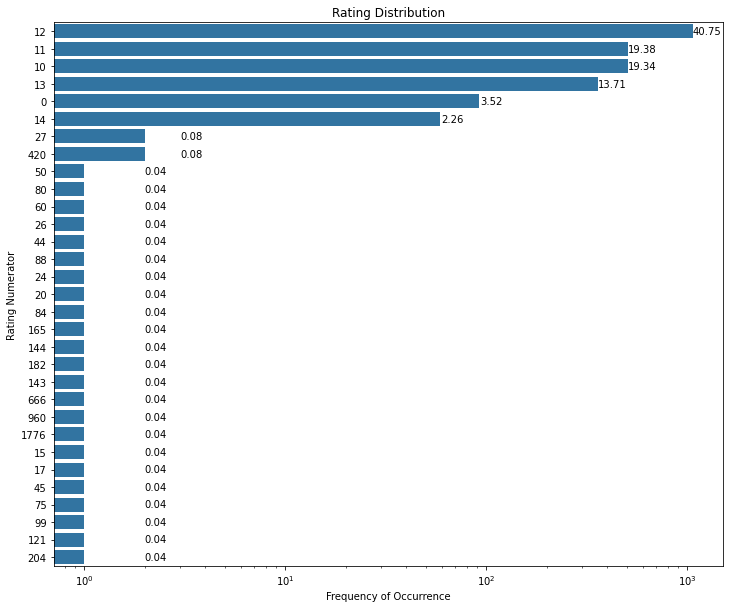

In [171]:
from matplotlib.ticker import ScalarFormatter

    
from matplotlib import rcParams
def drawBarChart(dataframe,title, xlabel,ylabel,xscale):
    # get order of bars by frequency
    type_values = dataframe.index
    # Compute largest proportion
    # Returns the sum of frequency of all not-null values in `type` column
    sum_of_freq = dataframe.sum()
    
    
    max_numerator_count = dataframe[12]
    
    max_prop = max_numerator_count / sum_of_freq
    # establish tick locations and create plot
    base_color = sb.color_palette()[0]
    tick_props = np.arange(0, max_prop, 0.1)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]
    base_color = sb.color_palette()[0]
    sb.countplot(data = df_twitter_archive_master, y = 'rating_numerator', color = base_color, order = type_values)
    plt.xticks(tick_props * sum_of_freq, tick_names)
    plt.xscale(xscale)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Specify the figure size in inches, for both X, and Y axes
    rcParams['figure.figsize'] = 20,10
    # Logic to print the proportion text on the bars
    j=0
    for i in dataframe.index:
        # Remember, type_counts contains the frequency of unique values in the `type` column in decreasing order.
        count = dataframe[i]
        # Convert count into a percentage, and then into string
        pct_string = '{:0.2f}'.format(100*count/sum_of_freq)
        # Print the string value on the bar. 
        # Read more about the arguments of text() function [here](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html)
        plt.text(count+1, j, pct_string, va='center')
        j = j+1
drawBarChart(df,'Rating Distribution', 'Frequency of Occurrence','Rating Numerator','log')

In [173]:
df_retweets.head()

,tweet_id,tweet_timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,growth_stage_value
0,886054160059072513,2017-07-15 02:45:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,886053734421102592,19607400,2017-07-15 02:44:07+00:00,https://twitter.com/dog_rates/status/886053434...,12,10,None,None
1,885311592912609280,2017-07-13 01:35:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,830583320585068544,4196983835,2017-02-12 01:04:29+00:00,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None
2,879130579576475649,2017-06-26 00:13:58+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,878057613040115712,4196983835,2017-06-23 01:10:23+00:00,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None
3,878404777348136964,2017-06-24 00:09:53+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,878281511006478336,4196983835,2017-06-23 16:00:04+00:00,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None
4,878316110768087041,2017-06-23 18:17:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,669000397445533696,4196983835,2015-11-24 03:51:38+00:00,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None


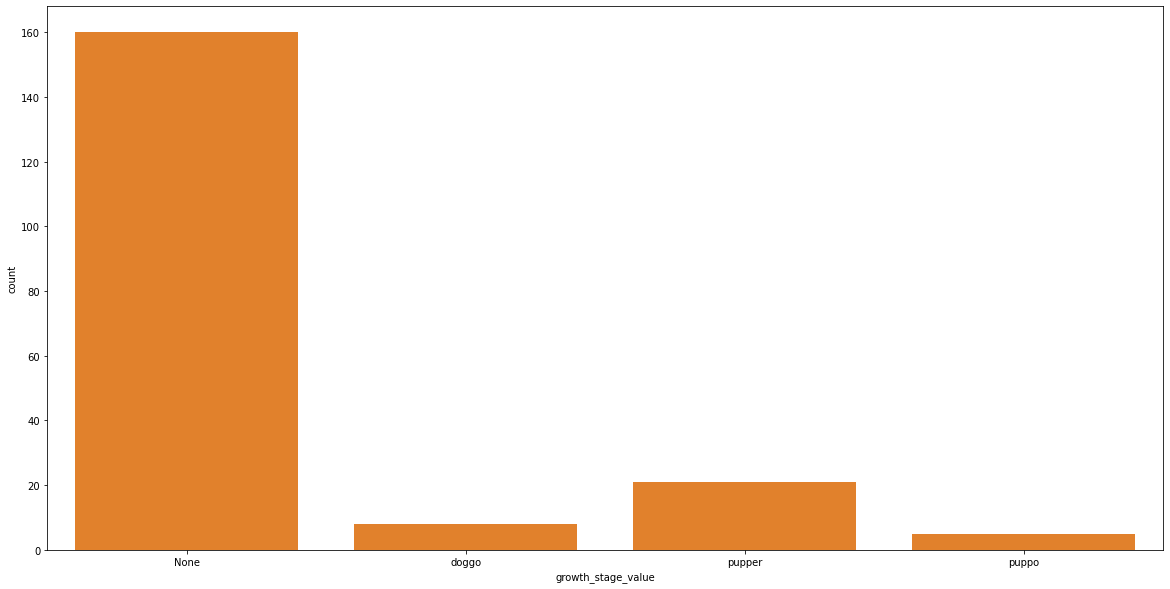

In [174]:
base_color = sb.color_palette()[1]
sb.countplot(data=df_retweets, x="growth_stage_value",color=base_color);

In [175]:
df_retweets['growth_stage_value'].value_counts()

None      160
pupper     21
doggo       8
puppo       5
Name: growth_stage_value, dtype: int64

<AxesSubplot:xlabel='growth_stage_value', ylabel='count'>

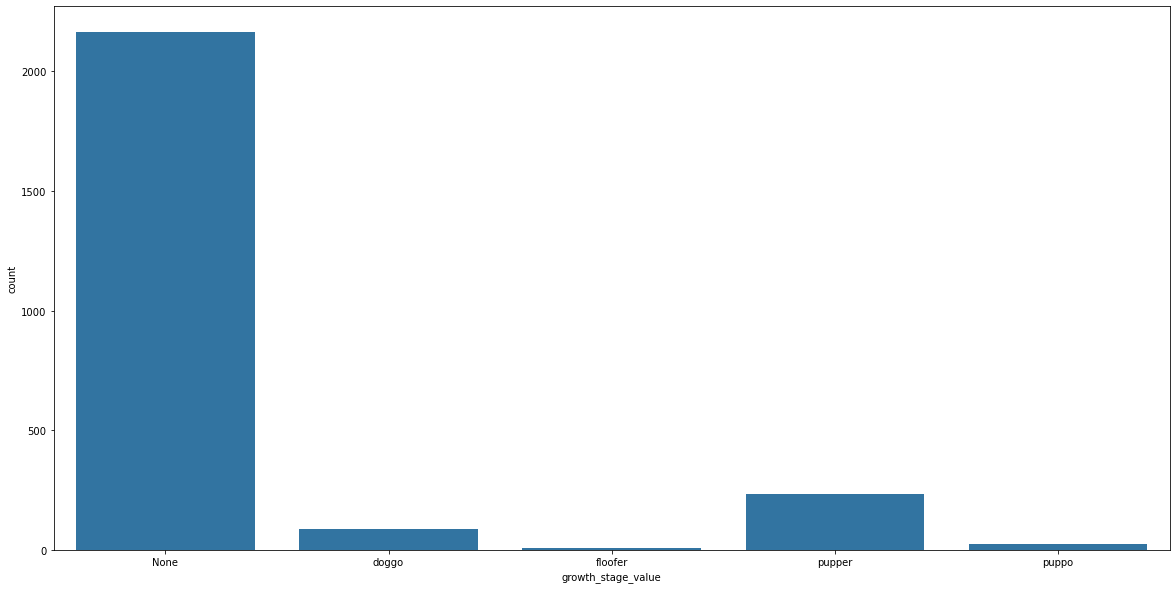

In [176]:
base_color = sb.color_palette()[0]
sb.countplot(data=df_twitter_archive_master, x="growth_stage_value",color=base_color)



In [177]:
df_twitter_archive_master['growth_stage_value'].value_counts()

None       2164
pupper      234
doggo        86
puppo        25
floofer      10
Name: growth_stage_value, dtype: int64

Text(0, 0.5, 'Frequency of Certainties')

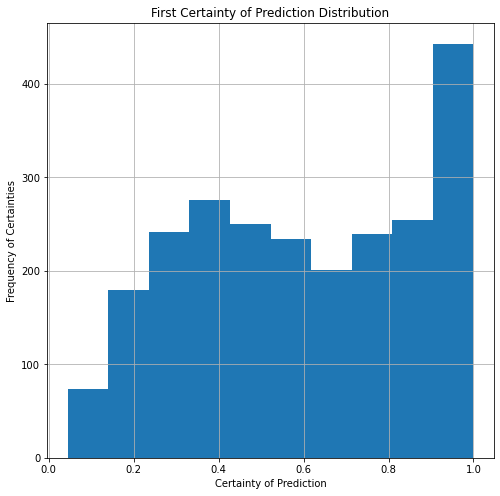

In [178]:
df_twitter_archive_master['tp1_confidence'].hist(figsize=(8,8));
plt.title("First Certainty of Prediction Distribution")
plt.xlabel("Certainty of Prediction")
plt.ylabel("Frequency of Certainties")
    

In [184]:
df_twitter_archive_master['tp1_confidence'].mode()

0    0.843799
1    0.945523
dtype: float64

Text(0, 0.5, 'Frequency of Certainties')

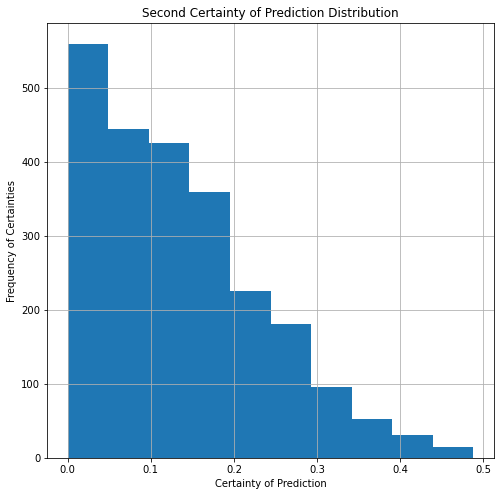

In [182]:
df_twitter_archive_master['tp2_confidence'].hist(figsize=(8,8))
plt.title("Second Certainty of Prediction Distribution")
plt.xlabel("Certainty of Prediction")
plt.ylabel("Frequency of Certainties")

Text(0, 0.5, 'Frequency of Certainties')

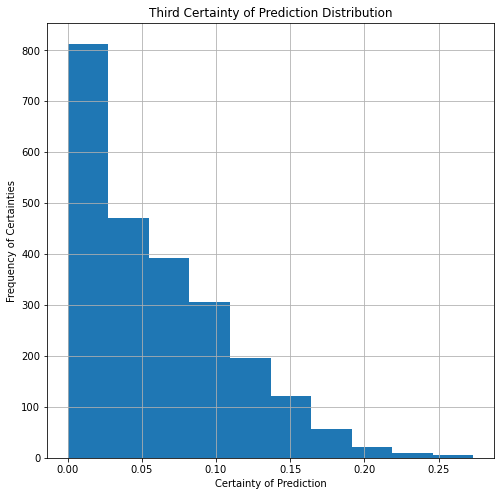

In [183]:
df_twitter_archive_master['tp3_confidence'].hist(figsize=(8,8))
plt.title("Third Certainty of Prediction Distribution")
plt.xlabel("Certainty of Prediction")
plt.ylabel("Frequency of Certainties")

<a id='insights'></a>
## Insights

1. Rating Numerator has 12 as the modal value. 
2. The values of `tp3_confidence` has an exponential distribution. 
3. The values of `tp1_confidence` is bimodal.
4. The values of tp2_confidence are seeming exponentially distributed as well.
5. Floofer is the least classification of dogs at WeRateDogs archive.
6. Many dogs were not classified to be under any growth category.
